In [12]:
import itertools
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
from sklearn.metrics import mean_squared_error, r2_score
import yaml
from tqdm import tqdm 
import mlflow
from glob import glob

# Get the current project path (where you open the notebook)
# and go up two levels to get the project path
current_dir = Path.cwd()
proj_path = current_dir.parent.parent

# make the code in src available to import in this notebook
import sys
sys.path.append(os.path.join(proj_path,'src'))

import xgboost as xgb
from xgboost import XGBClassifier

from metrics import *
from utils import *


# Catalog contains all the paths related to datasets
with open(os.path.join(proj_path, 'conf/catalog.yml'), "r") as f:
    catalog = yaml.safe_load(f)['olist']
    
# Params contains all of the dataset creation parameters and model parameters
with open(os.path.join(proj_path, 'conf/params.yml'), "r") as f:
    params = yaml.safe_load(f)


In [13]:
prod_categories = params['olist']['product_categories']
date_ranges = make_dates(params['olist']['experiment_dates'])

In [14]:
# Aggregate all predictions of each model for exp1

all_product_categories = {}
for prod_cat in prod_categories:
    xgb_exp1 = pd.read_csv(proj_path / catalog['results']['dir'] / f'xgb_exp1_{prod_cat}.csv')
    xgb_exp2 =pd.read_csv(proj_path / catalog['results']['dir'] / f'xgb_exp2_{prod_cat}.csv')
    lstm_exp1 =pd.read_csv(proj_path / catalog['results']['dir'] / f'lstm_exp1_{prod_cat}.csv')
    lstm_exp2 =pd.read_csv(proj_path / catalog['results']['dir'] / f'lstm_exp2_{prod_cat}.csv')

    # clean up each experiments and standardize their outputs here
    xgb_exp1 = xgb_exp1.rename(columns={'preds': 'y_pred_xgb'})
    xgb_exp2 = xgb_exp2.rename(columns={'preds': 'y_pred_xgb_gtrend'})
    lstm_exp1 = lstm_exp1.rename(columns={'y_pred': 'y_pred_lstm'}) # can be lt_preds
    lstm_exp2 = lstm_exp2.rename(columns={'y_pred': 'y_pred_lstm_gtrend'})

    # Sets the index the same for all dfs so they can be concatenated based on the index
    xgb_exp1.set_index('dates', inplace=True)
    xgb_exp2.set_index('dates', inplace=True)
    lstm_exp1.set_index('dates', inplace=True)
    lstm_exp2.set_index('dates', inplace=True)

    df = pd.concat([xgb_exp1[['y_true','y_pred_xgb']],
                    xgb_exp2['y_pred_xgb_gtrend'],
                    lstm_exp1['y_pred_lstm'],
                    lstm_exp2['y_pred_lstm_gtrend']], axis=1)
    
    all_product_categories[prod_cat] = df


In [15]:
def get_min_max(df, date_ranges):
    
    _metrics_xgb = []
    _metrics_xgb_gtrends = []
    _metrics_lstm = []
    _metrics_lstm_gtrends = []
    
    for window in date_ranges.itertuples():
        # Filter period
        temp = df[(pd.to_datetime(df.index) >= window[5]) & 
                  (pd.to_datetime(df.index) <= window[6])]
        _metrics_xgb.append(get_metrics(temp['y_true'],temp['y_pred_xgb']))
        _metrics_xgb_gtrends.append(get_metrics(temp['y_true'],temp['y_pred_xgb_gtrend']))
        _metrics_lstm.append(get_metrics(temp['y_true'],temp['y_pred_lstm']))
        _metrics_lstm_gtrends.append(get_metrics(temp['y_true'],temp['y_pred_lstm_gtrend']))
    
    # Get the min and max for each metric for each model
    return pd.DataFrame({'model':['xgb','xgb_gtrend','lstm','lstm_gtrend'],
                      'min_wape':[pd.DataFrame(_metrics_xgb)['wape'].min(),
                                 pd.DataFrame(_metrics_xgb_gtrends)['wape'].min(),
                                 pd.DataFrame(_metrics_lstm)['wape'].min(),
                                 pd.DataFrame(_metrics_lstm_gtrends)['wape'].min()],
                      'min_rmse':[pd.DataFrame(_metrics_xgb)['rmse'].min(),
                                 pd.DataFrame(_metrics_xgb_gtrends)['rmse'].min(),
                                 pd.DataFrame(_metrics_lstm)['rmse'].min(),
                                 pd.DataFrame(_metrics_lstm_gtrends)['rmse'].min()],
                      'min_r2':[pd.DataFrame(_metrics_xgb)['r2'].min(),
                                 pd.DataFrame(_metrics_xgb_gtrends)['r2'].min(),
                                 pd.DataFrame(_metrics_lstm)['r2'].min(),
                                 pd.DataFrame(_metrics_lstm_gtrends)['r2'].min()],
                     'min_mape':[pd.DataFrame(_metrics_xgb)['mape'].min(),
                                 pd.DataFrame(_metrics_xgb_gtrends)['mape'].min(),
                                 pd.DataFrame(_metrics_lstm)['mape'].min(),
                                 pd.DataFrame(_metrics_lstm_gtrends)['mape'].min()],
                     'max_wape':[pd.DataFrame(_metrics_xgb)['wape'].max(),
                                 pd.DataFrame(_metrics_xgb_gtrends)['wape'].max(),
                                 pd.DataFrame(_metrics_lstm)['wape'].max(),
                                 pd.DataFrame(_metrics_lstm_gtrends)['wape'].max()],
                      'max_rmse':[pd.DataFrame(_metrics_xgb)['rmse'].max(),
                                 pd.DataFrame(_metrics_xgb_gtrends)['rmse'].max(),
                                 pd.DataFrame(_metrics_lstm)['rmse'].max(),
                                 pd.DataFrame(_metrics_lstm_gtrends)['rmse'].max()],
                      'max_r2':[pd.DataFrame(_metrics_xgb)['r2'].max(),
                                 pd.DataFrame(_metrics_xgb_gtrends)['r2'].max(),
                                 pd.DataFrame(_metrics_lstm)['r2'].max(),
                                 pd.DataFrame(_metrics_lstm_gtrends)['r2'].max()],
                     'max_mape':[pd.DataFrame(_metrics_xgb)['mape'].max(),
                                 pd.DataFrame(_metrics_xgb_gtrends)['mape'].max(),
                                 pd.DataFrame(_metrics_lstm)['mape'].max(),
                                 pd.DataFrame(_metrics_lstm_gtrends)['mape'].max()]})
    

In [19]:
# metrics_df_xgb = pd.DataFrame()
metrics_df = pd.DataFrame()

for model in ['xgb', 'lstm']:
    for prod_cat in prod_categories:

        temp = all_product_categories[prod_cat]

        # Get metrics for each model
        metrics_xgb = get_metrics(temp['y_true'],temp[f'y_pred_{model}'])
        metrics_xgb_gtrends = get_metrics(temp['y_true'],temp[f'y_pred_{model}_gtrend'])
        metrics_lstm = get_metrics(temp['y_true'],temp['y_pred_lstm'])
        metrics_lstm_gtrends = get_metrics(temp['y_true'],temp['y_pred_lstm_gtrend'])

        results = pd.DataFrame([metrics_xgb,
                                metrics_xgb_gtrends,
                                metrics_lstm,
                                metrics_lstm_gtrends], 
                           index=['xgb','xgb_gtrend','lstm','lstm_gtrend'])
        
        results['product_category'] = prod_cat

        results = results.reset_index().rename(columns={'index':'model'})

        # Calculate the ranks for each metric
        results['rank_mape'] = results.rank(axis=0)['mape']
        results['rank_wape'] = results.rank(axis=0)['wape']
        results['rank_rmse'] = results.rank(axis=0)['rmse']
        results['rank_r2'] = results.rank(axis=0)['r2']
        min_max_df = get_min_max(df, make_dates(params['olist']['experiment_dates']))
        results = results.merge(min_max_df, how='inner',on='model')  

        # Calculate the minimum and maximum of each fold.

        metrics_df = metrics_df.append(results).reset_index(drop=True)

In [20]:
metrics_df

,model,wape,rmse,r2,mape,product_category,rank_mape,rank_wape,rank_rmse,rank_r2,min_wape,min_rmse,min_r2,min_mape,max_wape,max_rmse,max_r2,max_mape
0,xgb,6051.712185,48.561495,-1.139324,0.205683,bed_bath_table,1.0,1.0,1.0,4.0,357.393939,18.754999,-319.289157,0.285794,4872.618280,66.236319,-0.683014,0.694746
1,xgb_gtrend,8298.676208,71.294284,-3.611073,0.330868,bed_bath_table,4.0,2.0,4.0,1.0,459.684615,14.491377,-371.289157,0.205684,4327.033186,52.709107,0.088070,0.492476
2,lstm,8350.223509,62.215337,-2.511458,0.278532,bed_bath_table,2.0,3.0,2.0,3.0,416.480781,10.898269,-346.838103,0.110261,4068.875249,42.478349,-0.158686,0.662731
3,lstm_gtrend,9198.816791,65.673240,-2.912636,0.306336,bed_bath_table,3.0,4.0,3.0,2.0,463.667804,7.383891,-415.759211,0.102406,4434.248455,46.496649,-0.065140,0.868294
4,xgb,7030.122302,65.693179,-1.128104,0.327671,health_beauty,1.0,1.0,1.0,4.0,357.393939,18.754999,-319.289157,0.285794,4872.618280,66.236319,-0.683014,0.694746
5,xgb_gtrend,8309.892199,79.944512,-2.151590,0.387057,health_beauty,3.0,2.0,3.0,2.0,459.684615,14.491377,-371.289157,0.205684,4327.033186,52.709107,0.088070,0.492476
6,lstm,9492.889900,73.980020,-1.698865,0.363657,health_beauty,2.0,3.0,2.0,3.0,416.480781,10.898269,-346.838103,0.110261,4068.875249,42.478349,-0.158686,0.662731
7,lstm_gtrend,11160.522036,88.714958,-2.881021,0.443134,health_beauty,4.0,4.0,4.0,1.0,463.667804,7.383891,-415.759211,0.102406,4434.248455,46.496649,-0.065140,0.868294
8,xgb,5984.430573,65.592016,-2.181488,0.482095,sports_leisure,4.0,3.0,3.0,2.0,357.393939,18.754999,-319.289157,0.285794,4872.618280,66.236319,-0.683014,0.694746
9,xgb_gtrend,6144.210696,68.242216,-2.443773,0.467655,sports_leisure,3.0,4.0,4.0,1.0,459.684615,14.491377,-371.289157,0.205684,4327.033186,52.709107,0.088070,0.492476


In [21]:
metrics_df_xgb = pd.DataFrame()
metrics_df_lstm = pd.DataFrame()

for model in ['xgb', 'lstm']:
    for prod_cat in prod_categories:

        temp = all_product_categories[prod_cat]

        # Get metrics for each model
        metrics = get_metrics(temp['y_true'],temp[f'y_pred_{model}'])
        metrics_gtrends = get_metrics(temp['y_true'],temp[f'y_pred_{model}_gtrend'])

        results = pd.DataFrame([metrics,
                                metrics_gtrends], 
                                index=[model,f'{model}_gtrend'])
        results['product_category'] = prod_cat
        results = results.reset_index().rename(columns={'index':'model'})

        # Calculate the ranks for each metric
        results['rank_mape'] = results.rank(axis=0)['mape']
        results['rank_wape'] = results.rank(axis=0)['wape']
        results['rank_rmse'] = results.rank(axis=0)['rmse']
        results['rank_r2'] = results.rank(axis=0)['r2']
        min_max_df = get_min_max(df, make_dates(params['olist']['experiment_dates']))
        # left to only include model specific
        results = results.merge(min_max_df, how='left',on='model')  

        # Calculate the minimum and maximum of each fold.
        if model == 'xgb':
            metrics_df_xgb = metrics_df_xgb.append(results).reset_index(drop=True)
        if model =='lstm':
            metrics_df_lstm = metrics_df_lstm.append(results).reset_index(drop=True)
        

In [23]:
metrics_df_xgb

,model,wape,rmse,r2,mape,product_category,rank_mape,rank_wape,rank_rmse,rank_r2,min_wape,min_rmse,min_r2,min_mape,max_wape,max_rmse,max_r2,max_mape
0,xgb,6051.712185,48.561495,-1.139324,0.205683,bed_bath_table,1.0,1.0,1.0,2.0,357.393939,18.754999,-319.289157,0.285794,4872.618280,66.236319,-0.683014,0.694746
1,xgb_gtrend,8298.676208,71.294284,-3.611073,0.330868,bed_bath_table,2.0,2.0,2.0,1.0,459.684615,14.491377,-371.289157,0.205684,4327.033186,52.709107,0.088070,0.492476
2,xgb,7030.122302,65.693179,-1.128104,0.327671,health_beauty,1.0,1.0,1.0,2.0,357.393939,18.754999,-319.289157,0.285794,4872.618280,66.236319,-0.683014,0.694746
3,xgb_gtrend,8309.892199,79.944512,-2.151590,0.387057,health_beauty,2.0,2.0,2.0,1.0,459.684615,14.491377,-371.289157,0.205684,4327.033186,52.709107,0.088070,0.492476
4,xgb,5984.430573,65.592016,-2.181488,0.482095,sports_leisure,2.0,1.0,1.0,2.0,357.393939,18.754999,-319.289157,0.285794,4872.618280,66.236319,-0.683014,0.694746
5,xgb_gtrend,6144.210696,68.242216,-2.443773,0.467655,sports_leisure,1.0,2.0,2.0,1.0,459.684615,14.491377,-371.289157,0.205684,4327.033186,52.709107,0.088070,0.492476
6,xgb,3968.998468,48.754166,-0.868095,0.365257,furniture_decor,2.0,2.0,1.0,2.0,357.393939,18.754999,-319.289157,0.285794,4872.618280,66.236319,-0.683014,0.694746
7,xgb_gtrend,3873.173713,49.799598,-0.949069,0.320968,furniture_decor,1.0,1.0,2.0,1.0,459.684615,14.491377,-371.289157,0.205684,4327.033186,52.709107,0.088070,0.492476
8,xgb,4047.135554,47.738218,-0.359963,0.271704,housewares,1.0,1.0,1.0,2.0,357.393939,18.754999,-319.289157,0.285794,4872.618280,66.236319,-0.683014,0.694746
9,xgb_gtrend,4412.398026,53.979452,-0.738809,0.300375,housewares,2.0,2.0,2.0,1.0,459.684615,14.491377,-371.289157,0.205684,4327.033186,52.709107,0.088070,0.492476


In [24]:
metrics_df_lstm

,model,wape,rmse,r2,mape,product_category,rank_mape,rank_wape,rank_rmse,rank_r2,min_wape,min_rmse,min_r2,min_mape,max_wape,max_rmse,max_r2,max_mape
0,lstm,8350.223509,62.215337,-2.511458,0.278532,bed_bath_table,1.0,1.0,1.0,2.0,416.480781,10.898269,-346.838103,0.110261,4068.875249,42.478349,-0.158686,0.662731
1,lstm_gtrend,9198.816791,65.673240,-2.912636,0.306336,bed_bath_table,2.0,2.0,2.0,1.0,463.667804,7.383891,-415.759211,0.102406,4434.248455,46.496649,-0.065140,0.868294
2,lstm,9492.889900,73.980020,-1.698865,0.363657,health_beauty,1.0,1.0,1.0,2.0,416.480781,10.898269,-346.838103,0.110261,4068.875249,42.478349,-0.158686,0.662731
3,lstm_gtrend,11160.522036,88.714958,-2.881021,0.443134,health_beauty,2.0,2.0,2.0,1.0,463.667804,7.383891,-415.759211,0.102406,4434.248455,46.496649,-0.065140,0.868294
4,lstm,5516.137893,53.193396,-1.092395,0.326743,sports_leisure,2.0,2.0,2.0,1.0,416.480781,10.898269,-346.838103,0.110261,4068.875249,42.478349,-0.158686,0.662731
5,lstm_gtrend,5326.259474,51.697593,-0.976373,0.320508,sports_leisure,1.0,1.0,1.0,2.0,463.667804,7.383891,-415.759211,0.102406,4434.248455,46.496649,-0.065140,0.868294
6,lstm,4141.214367,49.384925,-0.916745,0.369853,furniture_decor,2.0,1.0,2.0,1.0,416.480781,10.898269,-346.838103,0.110261,4068.875249,42.478349,-0.158686,0.662731
7,lstm_gtrend,4340.755601,48.872862,-0.877202,0.339917,furniture_decor,1.0,2.0,1.0,2.0,463.667804,7.383891,-415.759211,0.102406,4434.248455,46.496649,-0.065140,0.868294
8,lstm,4772.974156,54.209121,-0.753636,0.328402,housewares,1.0,1.0,1.0,2.0,416.480781,10.898269,-346.838103,0.110261,4068.875249,42.478349,-0.158686,0.662731
9,lstm_gtrend,5008.069389,56.984843,-0.937820,0.347119,housewares,2.0,2.0,2.0,1.0,463.667804,7.383891,-415.759211,0.102406,4434.248455,46.496649,-0.065140,0.868294


In [25]:
all_dfs_xgb = []
all_dfs_lstm = []

for metric in ['mape','rmse','wape','r2']:
    # Do this for xgb
    rank_df = pd.DataFrame(metrics_df_xgb.groupby('model')[f'rank_{metric}'].value_counts().rename(f'cnt_rank_{metric}')).reset_index()
    rank_df[f'rank_{metric}'] = rank_df[f'rank_{metric}'].astype(int)
    all_dfs_xgb.append(rank_df.pivot_table(index='model', columns=f'rank_{metric}', values=f'cnt_rank_{metric}').add_prefix(f'{metric}_'))
    
    # Do this for lstm
    rank_df = pd.DataFrame(metrics_df_lstm.groupby('model')[f'rank_{metric}'].value_counts().rename(f'cnt_rank_{metric}')).reset_index()
    rank_df[f'rank_{metric}'] = rank_df[f'rank_{metric}'].astype(int)
    all_dfs_lstm.append(rank_df.pivot_table(index='model', columns=f'rank_{metric}', values=f'cnt_rank_{metric}').add_prefix(f'{metric}_'))
    

In [26]:
pd.concat(all_dfs_xgb,axis=1)

,mape_1,mape_2,rmse_1,rmse_2,wape_1,wape_2,r2_1,r2_2
model,,,,,,,,
xgb,4,3,6,1,5,2,1,6
xgb_gtrend,3,4,1,6,2,5,6,1


In [27]:
pd.concat(all_dfs_lstm,axis=1)

,mape_1,mape_2,rmse_1,rmse_2,wape_1,wape_2,r2_1,r2_2
model,,,,,,,,
lstm,5,2,5,2,5,2,2,5
lstm_gtrend,2,5,2,5,2,5,5,2


In [28]:
# View individual ranks for each metrics per model
# You can switch all_dfs_xgb for all_dfs_lstm
for df_metric in all_dfs_xgb: # all_dfs_lstm
    display(df_metric)

rank_mape,mape_1,mape_2
model,,
xgb,4,3
xgb_gtrend,3,4


rank_rmse,rmse_1,rmse_2
model,,
xgb,6,1
xgb_gtrend,1,6


rank_wape,wape_1,wape_2
model,,
xgb,5,2
xgb_gtrend,2,5


rank_r2,r2_1,r2_2
model,,
xgb,1,6
xgb_gtrend,6,1


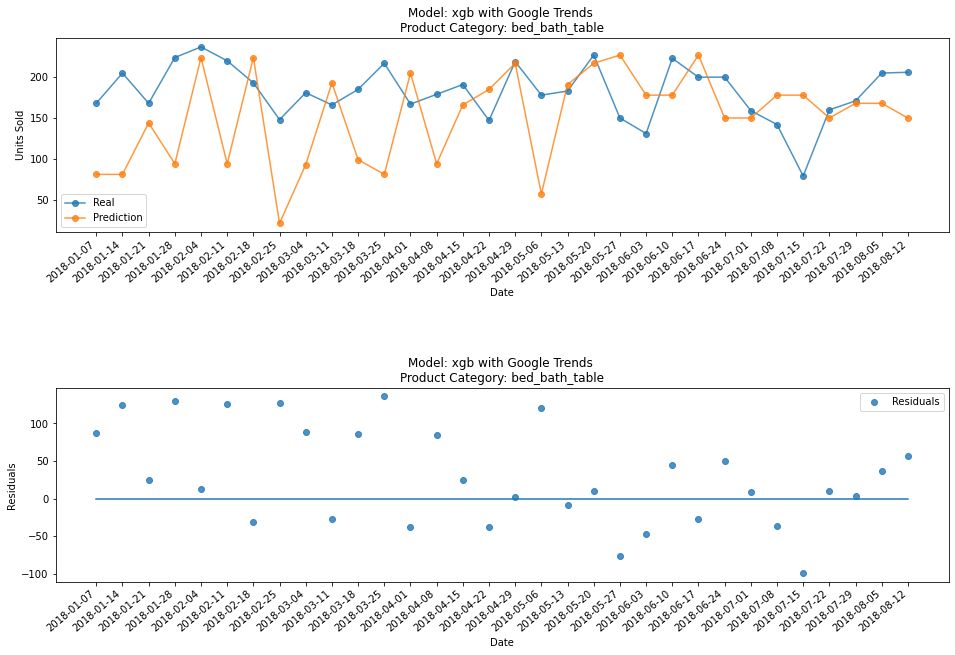

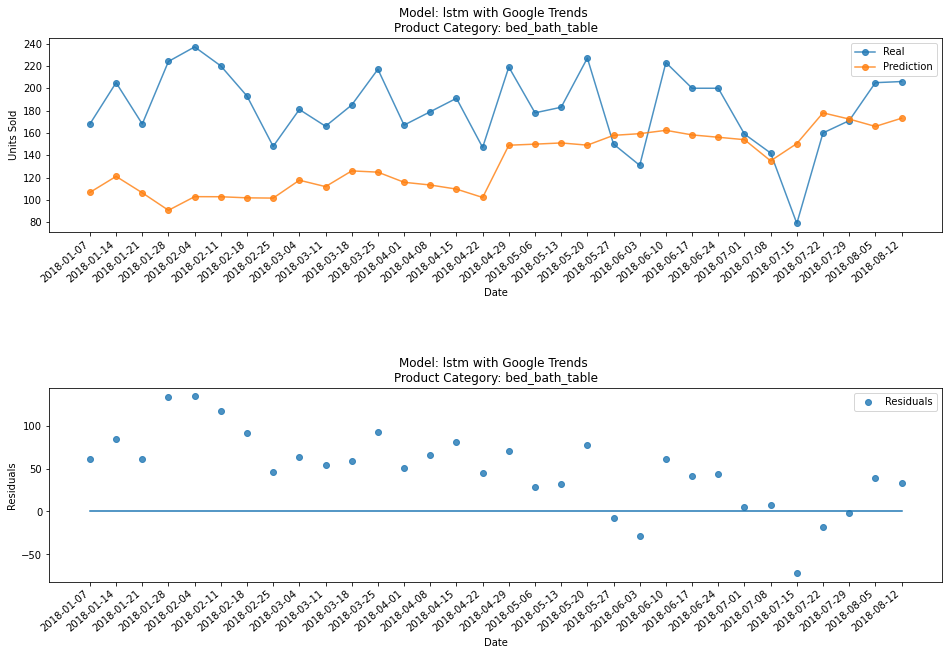

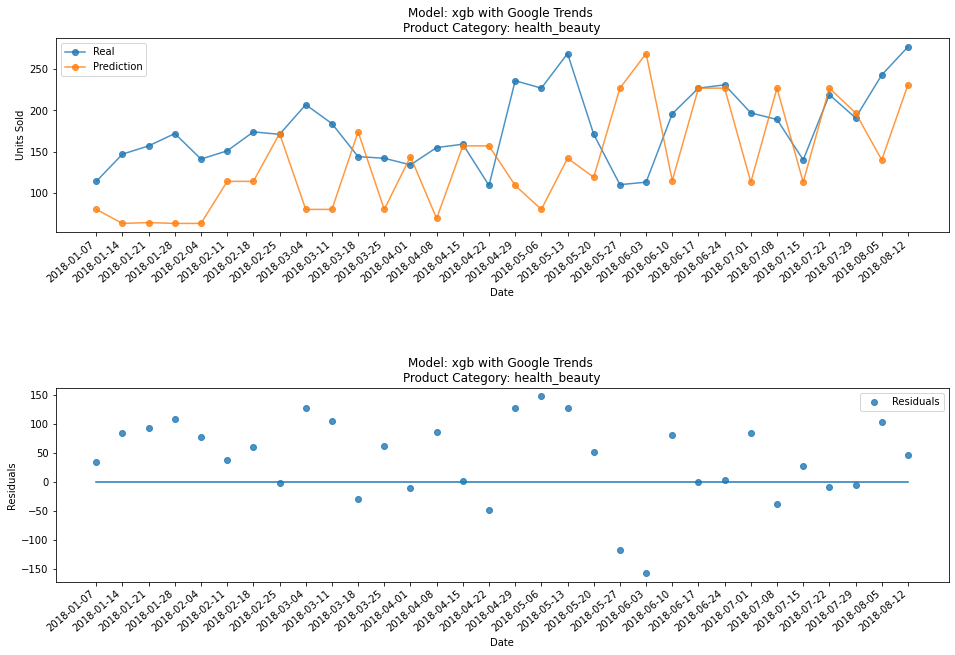

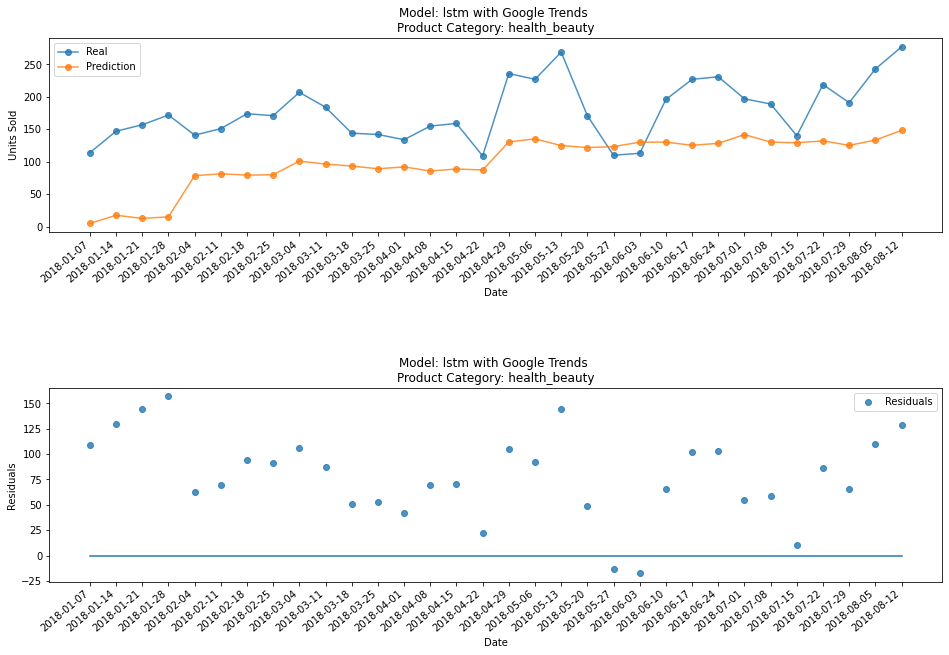

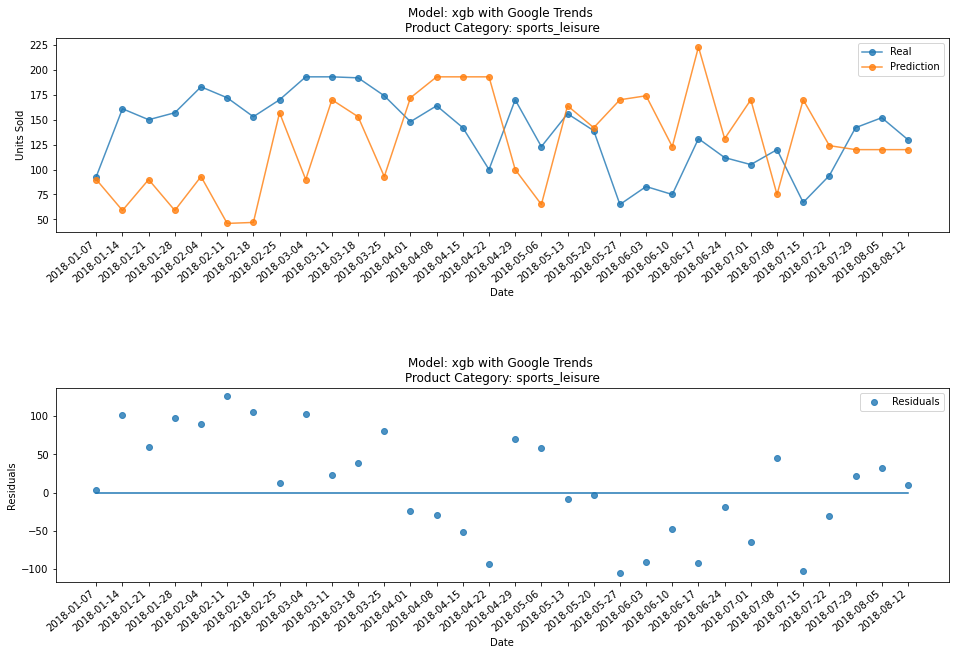

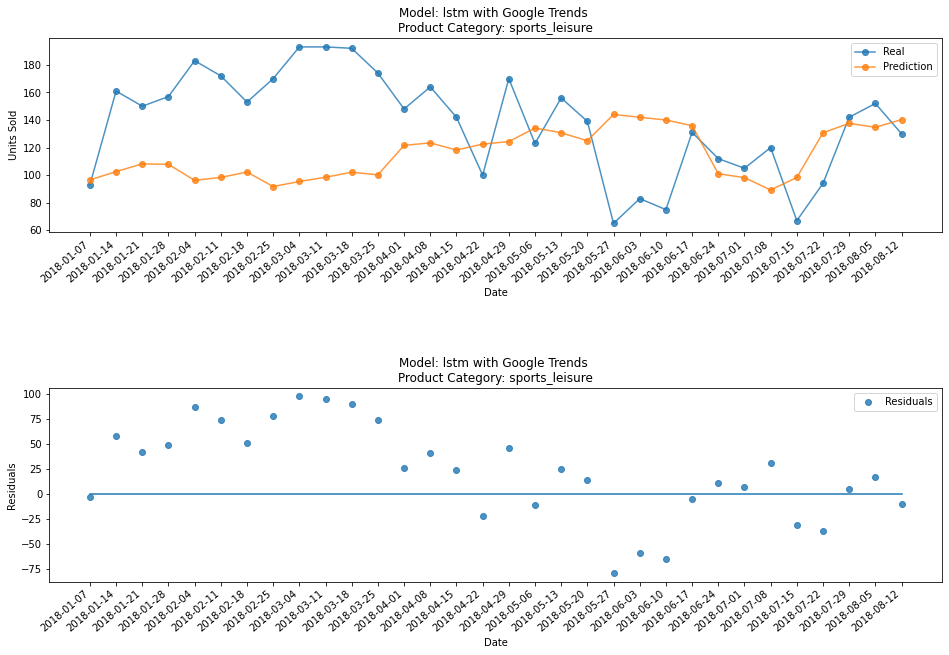

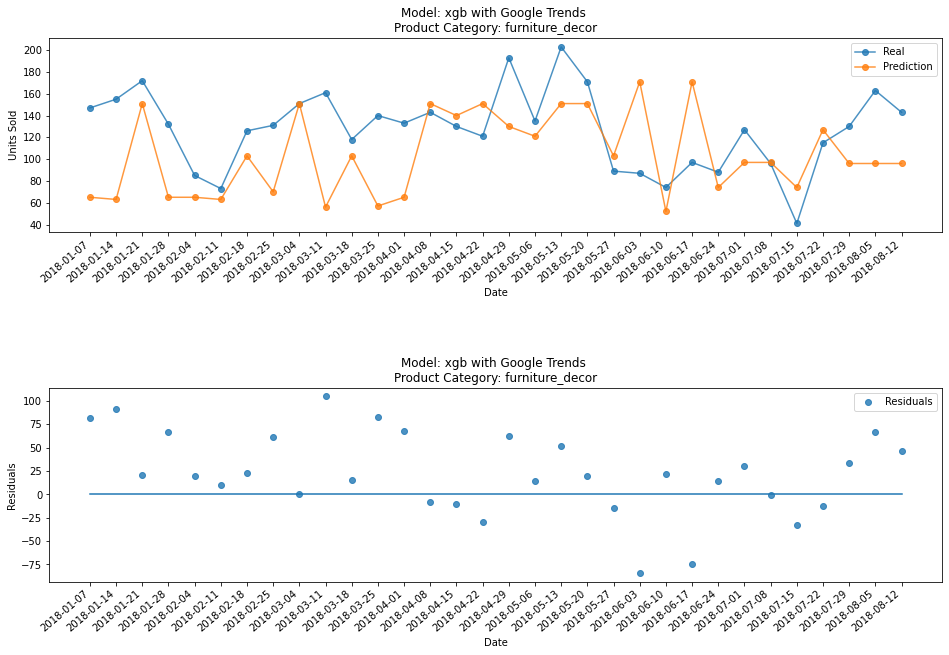

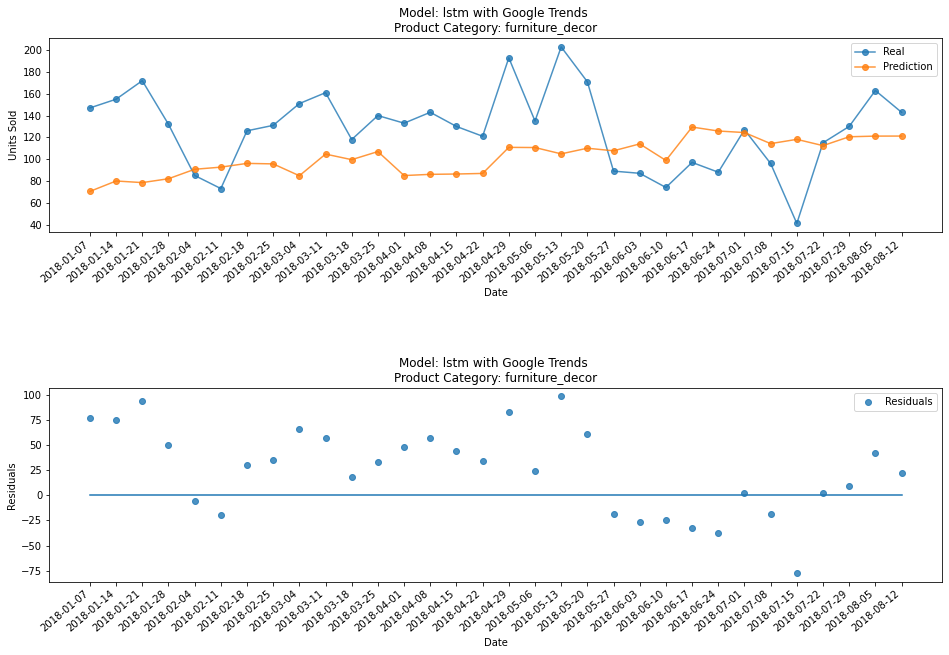

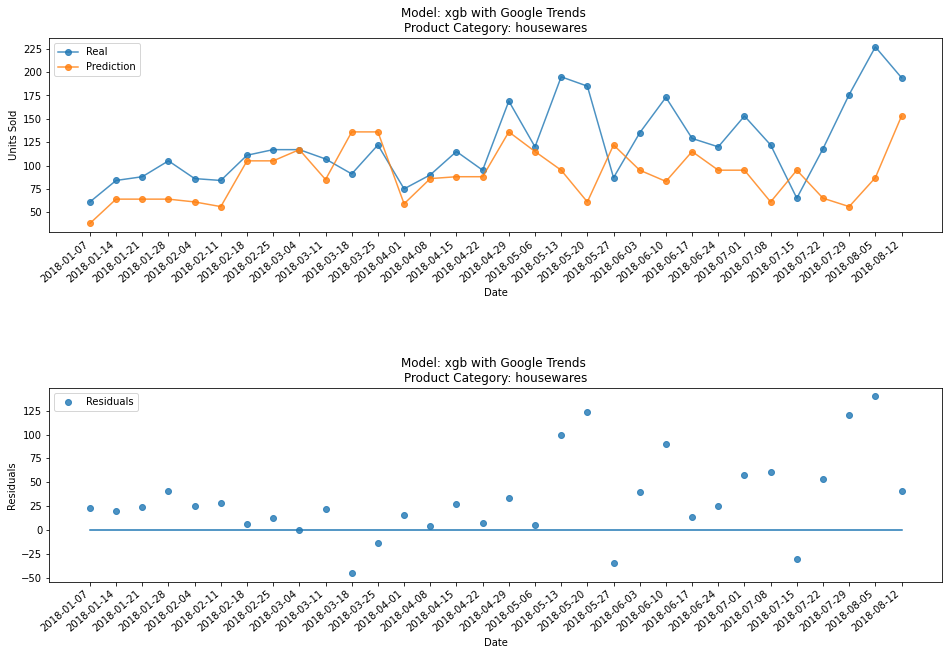

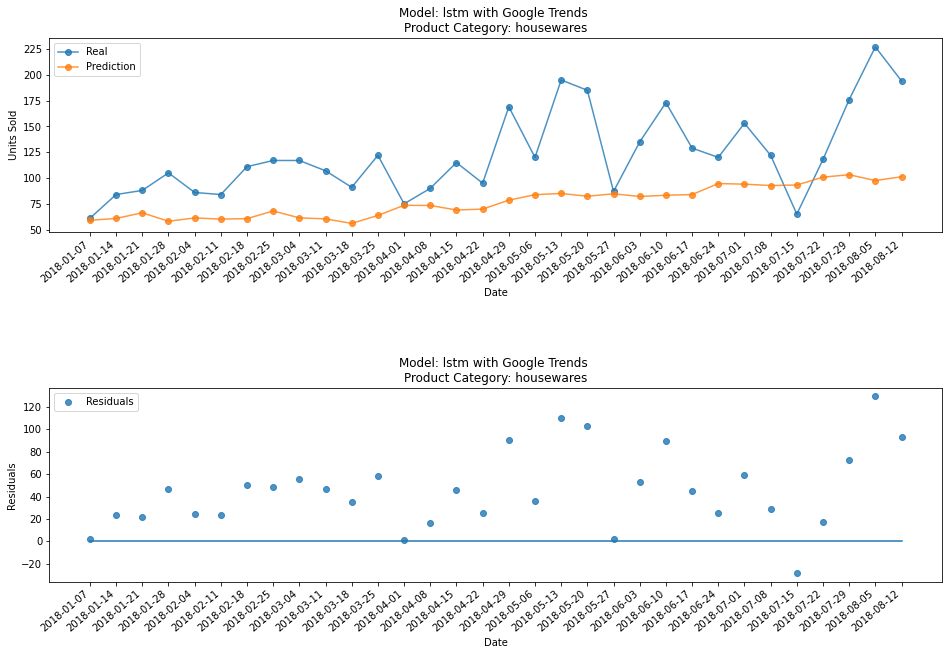

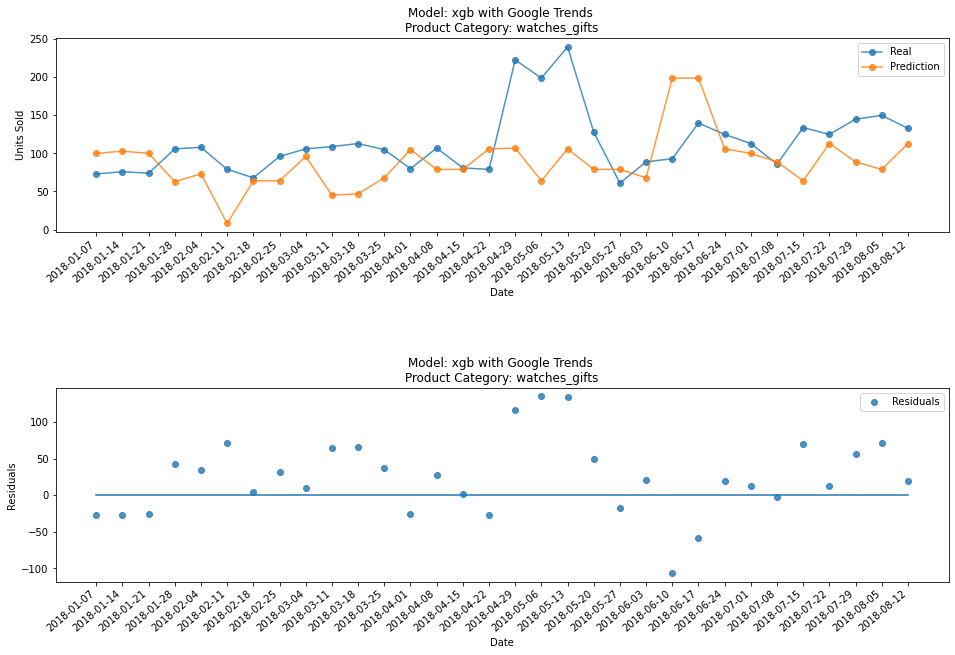

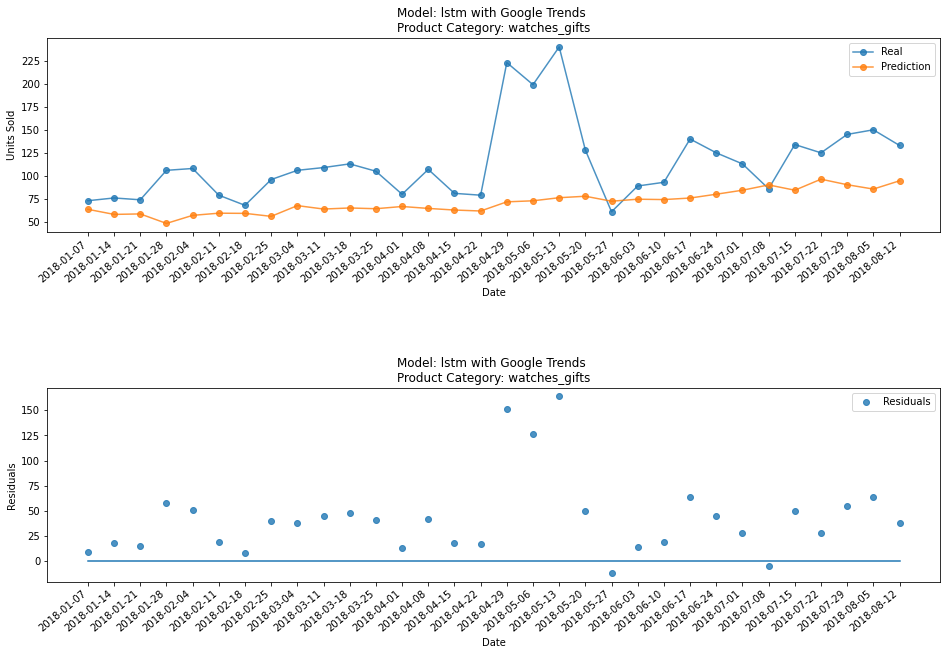

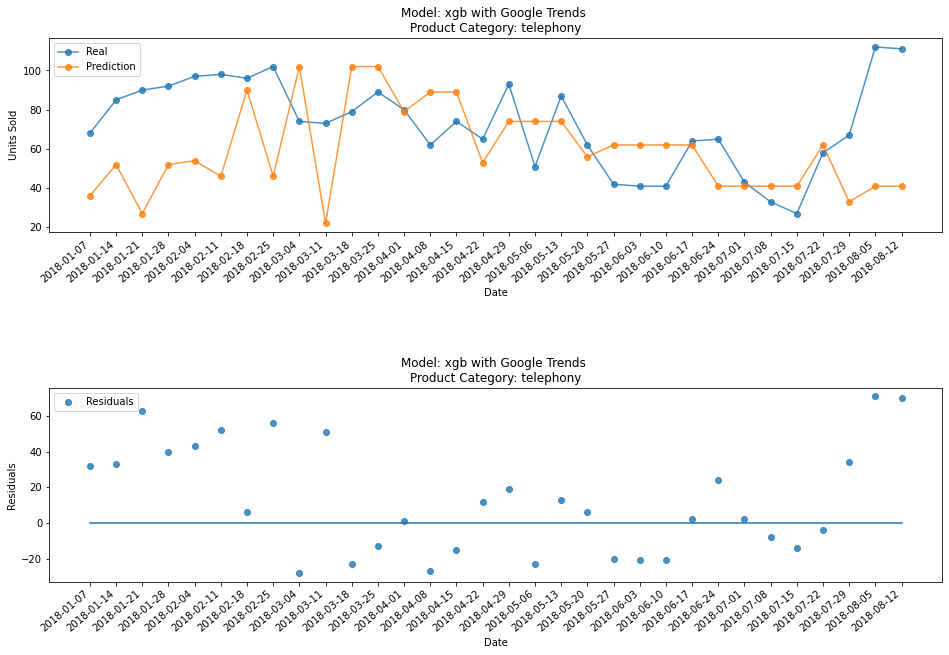

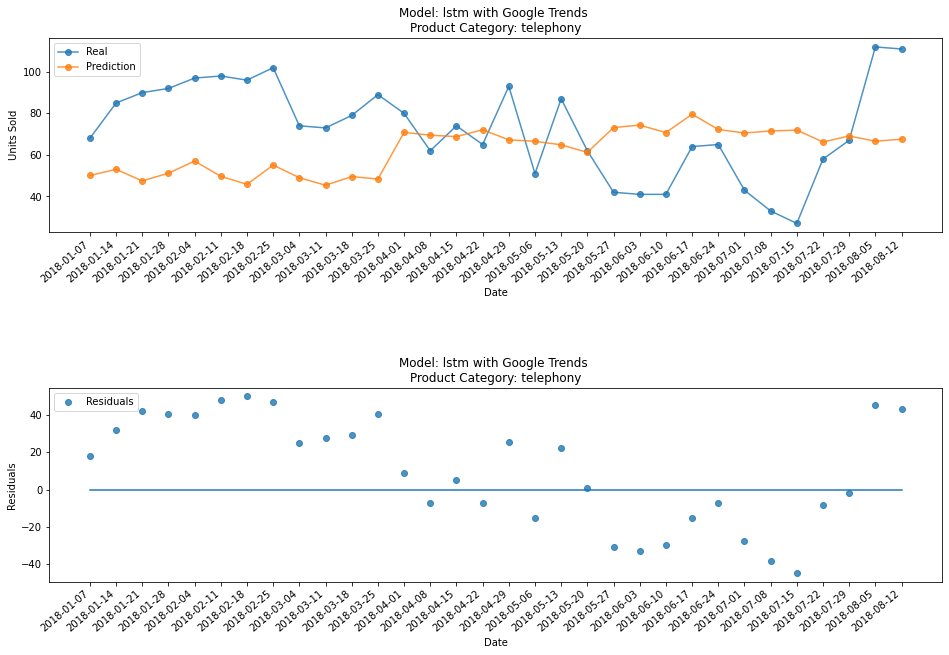

In [30]:
# Plot the forecast for each model (only with google trends)

for prod_cat in prod_categories:
    
    temp = all_product_categories[prod_cat]
    temp.sort_index(inplace=True)

    for model in ['xgb','lstm']:
        
        fig, axs = plt.subplots(2, 1, figsize=(16,10))
        plt.subplots_adjust(hspace=0.8)
        
        # Forecast
        axs[0].plot(temp['y_true'], marker='o', label='Real',alpha=0.8)
        axs[0].plot(temp[f'y_pred_{model}_gtrend'], marker='o', label='Prediction',alpha=0.8)
        axs[0].set_title(f'Model: {model} with Google Trends \nProduct Category: {prod_cat}')
        axs[0].set_xlabel('Date')
        axs[0].set_ylabel('Units Sold')
        axs[0].legend()
        for tick in axs[0].get_xticklabels():
            tick.set_rotation(40)
            tick.set_horizontalalignment('right')
            
        # Residuals
        axs[1].scatter(x=temp.index, y=(temp['y_true'] - temp[f'y_pred_{model}_gtrend']), marker='o', label='Residuals', alpha=0.8)
        axs[1].plot([0]*temp.shape[0])
        axs[1].set_title(f'Model: {model} with Google Trends \nProduct Category: {prod_cat}')
        axs[1].set_xlabel('Date')
        axs[1].set_ylabel('Residuals')
        axs[1].legend()
        for tick in axs[1].get_xticklabels():
            tick.set_rotation(40)
            tick.set_horizontalalignment('right')
            
        plt.show()
        
    print('\n\n\n')

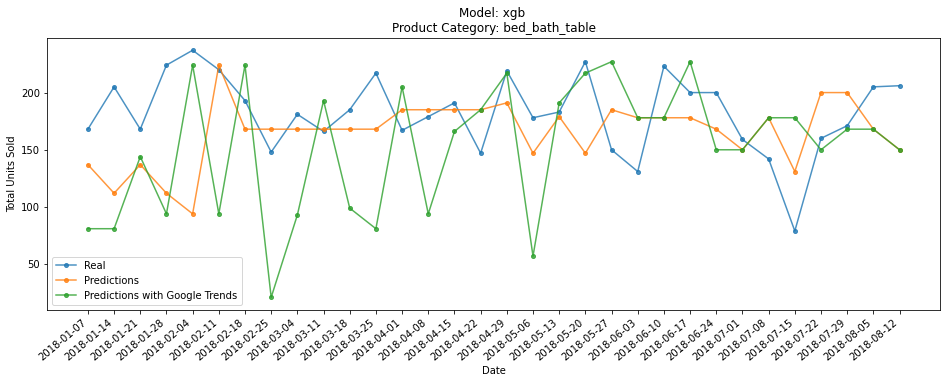

Std xgb: 27.84 and with Google Trends: 56.33


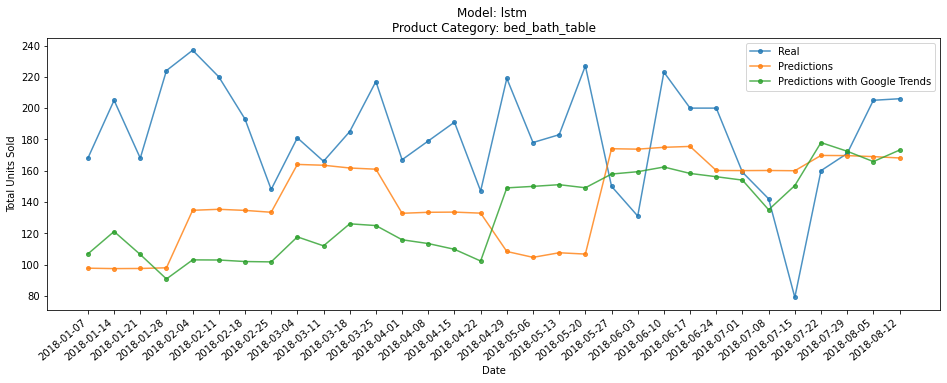

Std lstm: 27.58 and with Google Trends: 26.34






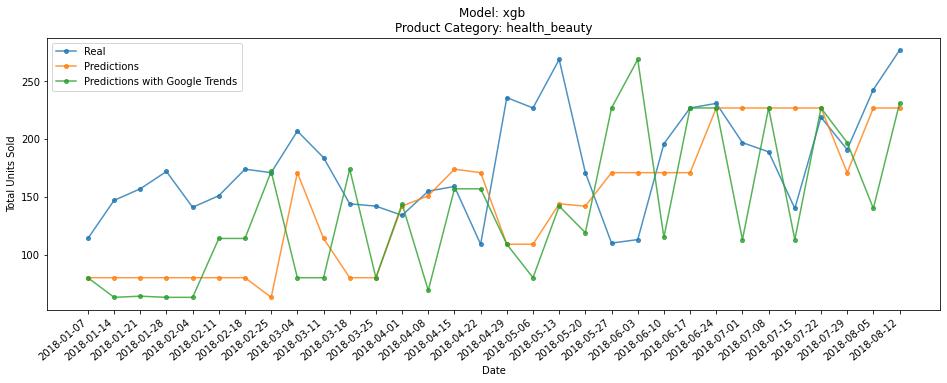

Std xgb: 57.08 and with Google Trends: 62.26


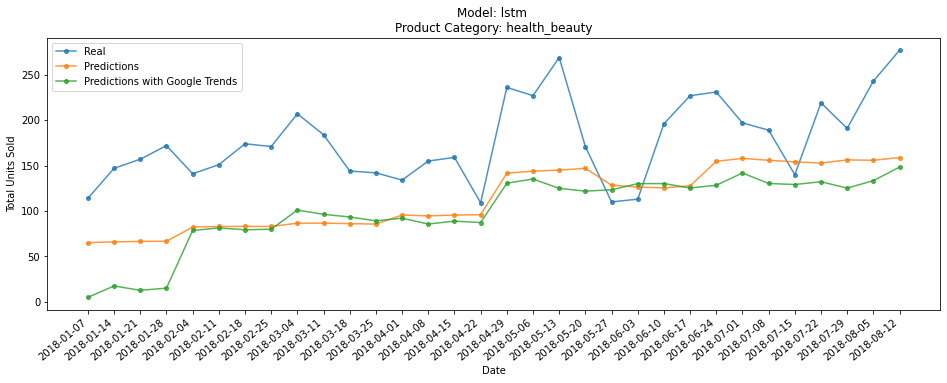

Std lstm: 34.04 and with Google Trends: 39.68






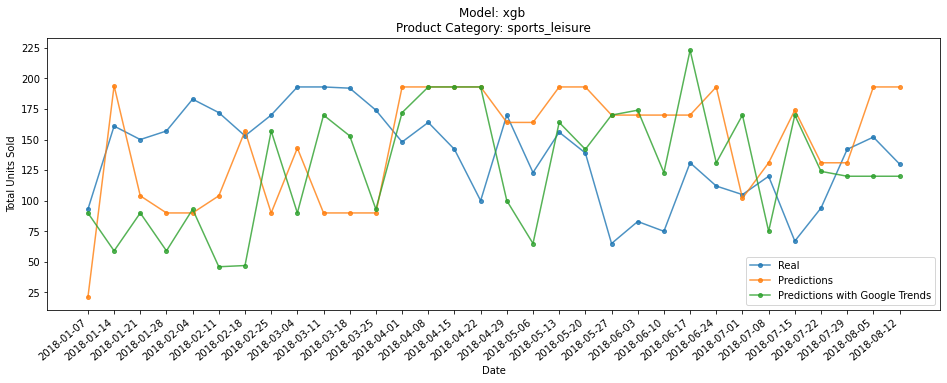

Std xgb: 46.36 and with Google Trends: 48.58


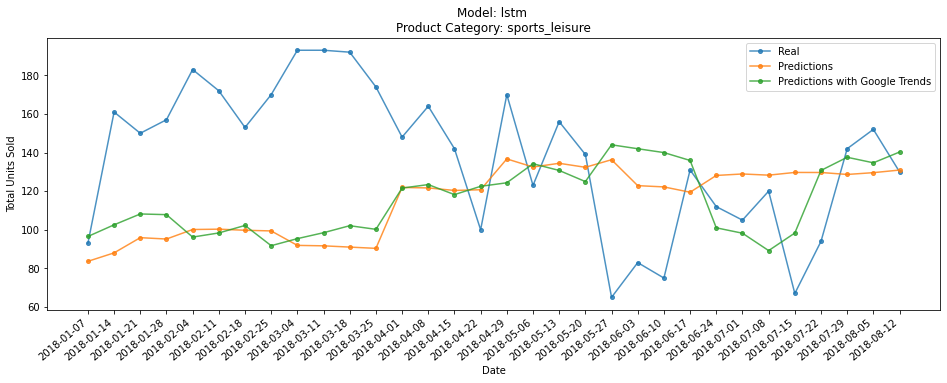

Std lstm: 17.47 and with Google Trends: 17.76






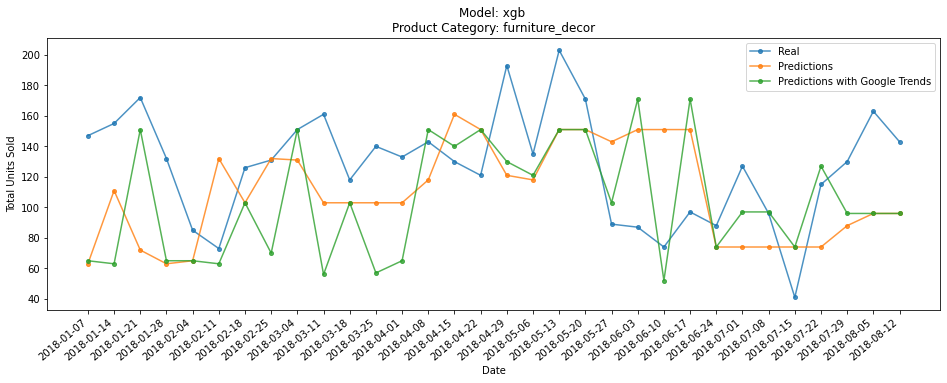

Std xgb: 31.58 and with Google Trends: 38.07


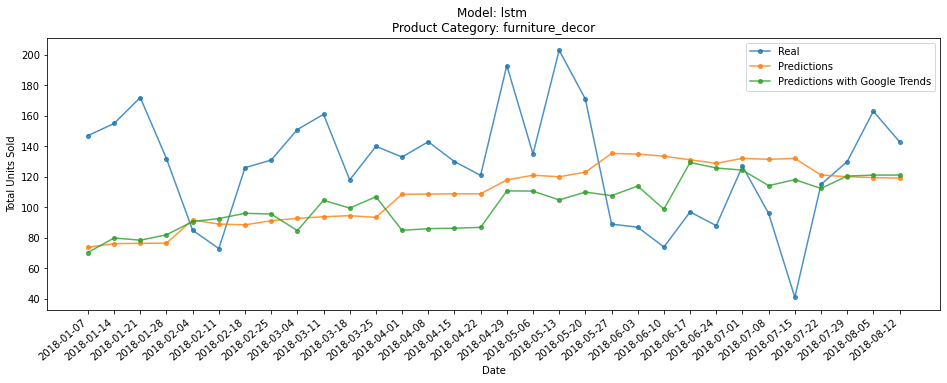

Std lstm: 19.89 and with Google Trends: 15.98






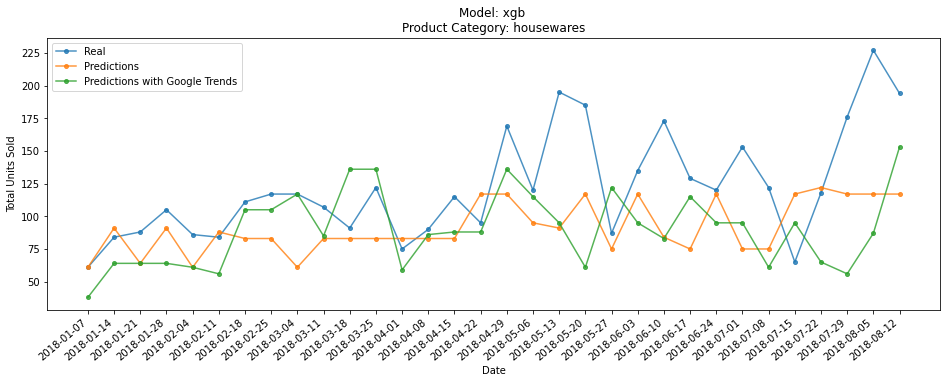

Std xgb: 19.74 and with Google Trends: 28.49


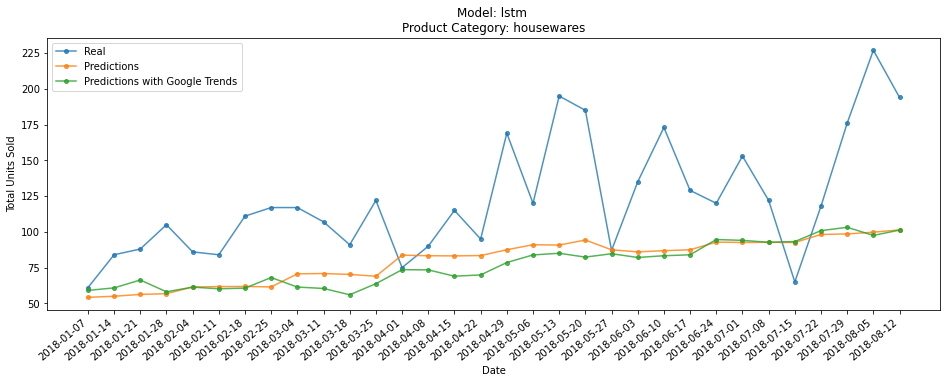

Std lstm: 15.06 and with Google Trends: 14.91






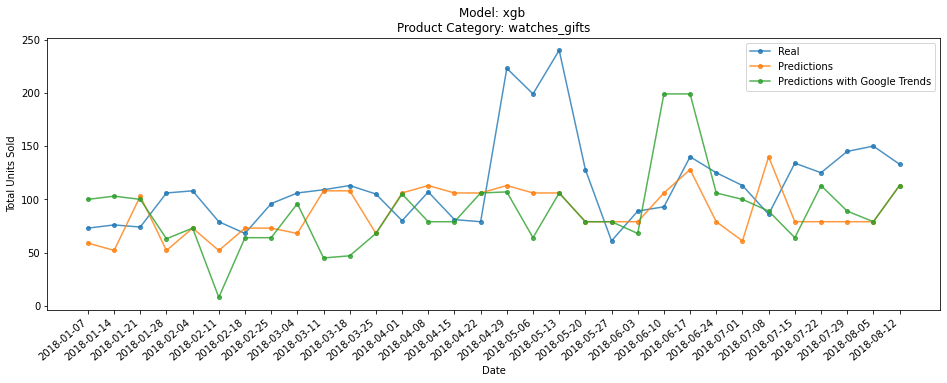

Std xgb: 23.23 and with Google Trends: 37.02


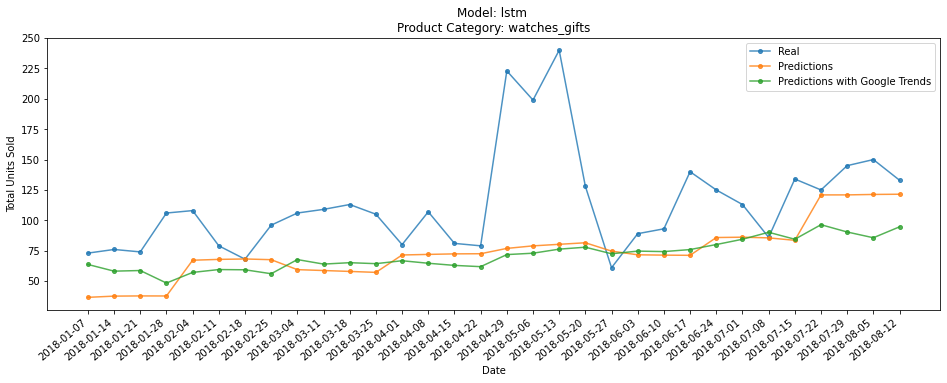

Std lstm: 22.77 and with Google Trends: 12.25






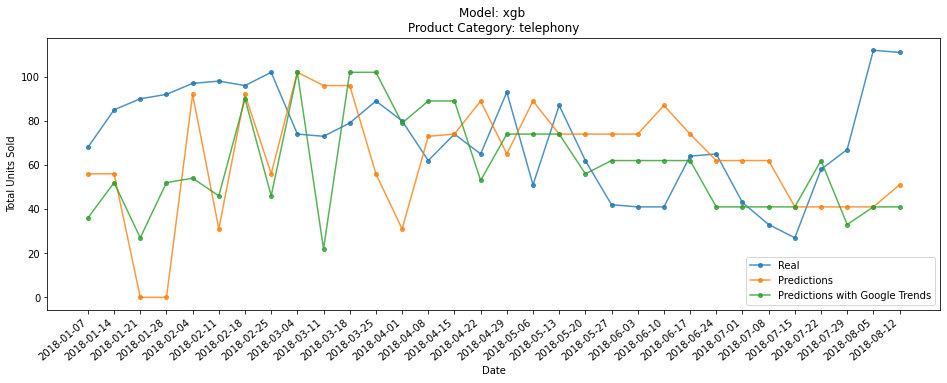

Std xgb: 25.65 and with Google Trends: 22.33


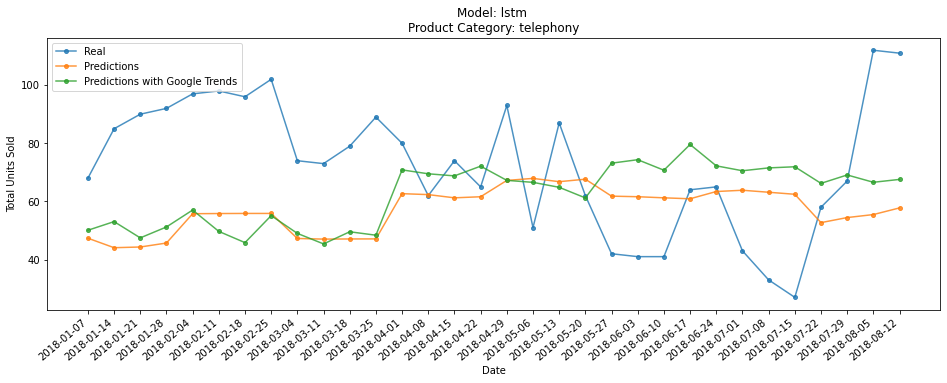

Std lstm: 7.49 and with Google Trends: 10.33






In [10]:
# Plot the forecast for each model

for prod_cat in prod_categories:
    
    temp = all_product_categories[prod_cat]
    temp.sort_index(inplace=True)

    for model in ['xgb','lstm']:
        
        fig, axs = plt.subplots(1,1, figsize=(16,5))
#         plt.figure(figsize=(16,8))
        plt.plot(temp['y_true'], marker='o', markersize=4, 
                 label='Real',alpha=0.8)
        plt.plot(temp[f'y_pred_{model}'], marker='o', markersize=4, 
                 label='Predictions',alpha=0.8)
        plt.plot(temp[f'y_pred_{model}_gtrend'], marker='o', markersize=4, 
                 label='Predictions with Google Trends',alpha=0.8)

        plt.title(f'Model: {model} \nProduct Category: {prod_cat}')
        plt.xlabel('Date')
        plt.ylabel('Total Units Sold')
        plt.legend()
        for tick in axs.get_xticklabels():
            tick.set_rotation(40)
            tick.set_horizontalalignment('right')
        plt.show()
        if model == 'xgb':
            print(f"Std xgb: {temp['y_pred_xgb'].std():.2f} and with Google Trends: {temp['y_pred_xgb_gtrend'].std():.2f}")
        if model == 'lstm':
            print(f"Std lstm: {temp['y_pred_lstm'].std():.2f} and with Google Trends: {temp['y_pred_lstm_gtrend'].std():.2f}")
        
    print('\n\n\n')
    

In [66]:
# When we add google trends, there seem to be more variation in the predictions

# Statistical Tests

In [32]:
from scipy import stats

In [35]:
# metrics_df_xgb

In [36]:
paired_results = pd.DataFrame()

xgb_gtrend_hyp = (
    metrics_df_xgb[['model','rmse','product_category']]
    .groupby(['model','product_category'])
    .mean()
    .reset_index()
    .pivot_table(index=['product_category'], columns=['model'], values='rmse')
)

paired_results['xgb'] = xgb_gtrend_hyp['xgb']
paired_results['xgb_gtrend'] = xgb_gtrend_hyp['xgb_gtrend']
paired_results['xgb - xgb_gtrend'] = paired_results['xgb'] - paired_results['xgb_gtrend']

summary_stats = pd.DataFrame()
summary_stats['std'] = paired_results.std(numeric_only=True, axis=0)
summary_stats['average'] = paired_results.mean(numeric_only=True, axis=0)


paired_results = paired_results.append(summary_stats.T)

t_test_val = pd.DataFrame({'xgb':['-'],
                       'xgb_gtrend':['-'],
                       'xgb - xgb_gtrend': [stats.ttest_rel(xgb_gtrend_hyp['xgb'], xgb_gtrend_hyp['xgb_gtrend'])[1]]})
t_test_val.index = ['p_value']

paired_results.append(t_test_val)

,xgb,xgb_gtrend,xgb - xgb_gtrend
bed_bath_table,48.5615,71.2943,-22.732790
furniture_decor,48.7542,49.7996,-1.045432
health_beauty,65.6932,79.9445,-14.251333
housewares,47.7382,53.9795,-6.241234
sports_leisure,65.592,68.2422,-2.650200
telephony,38.6761,33.0355,5.640647
watches_gifts,48.8809,57.2909,-8.410010
std,10.0002,15.6105,9.280462
average,51.9852,59.0838,-7.098622
p_value,-,-,0.089437


In [37]:
# LSTM

paired_results = pd.DataFrame()

lstm_gtrend_hyp = (
    metrics_df_lstm[['model','rmse','product_category']]
    .groupby(['model','product_category'])
    .mean()
    .reset_index()
    .pivot_table(index=['product_category'], columns=['model'], values='rmse')
)

paired_results['lstm'] = lstm_gtrend_hyp['lstm']
paired_results['lstm_gtrend'] = lstm_gtrend_hyp['lstm_gtrend']
paired_results['lstm - lstm_gtrend'] = paired_results['lstm'] - paired_results['lstm_gtrend']

summary_stats = pd.DataFrame()
summary_stats['std'] = paired_results.std(numeric_only=True, axis=0)
summary_stats['average'] = paired_results.mean(numeric_only=True, axis=0)


paired_results = paired_results.append(summary_stats.T)

t_test_val = pd.DataFrame({'lstm':['-'],
                           'lstm_gtrend':['-'],
                           'lstm - lstm_gtrend': [stats.ttest_rel(lstm_gtrend_hyp['lstm'], lstm_gtrend_hyp['lstm_gtrend'])[1]]})
t_test_val.index = ['p_value']

paired_results.append(t_test_val)

,lstm,lstm_gtrend,lstm - lstm_gtrend
bed_bath_table,62.2153,65.6732,-3.457903
furniture_decor,49.3849,48.8729,0.512062
health_beauty,73.98,88.715,-14.734938
housewares,54.2091,56.9848,-2.775722
sports_leisure,53.1934,51.6976,1.495803
telephony,30.432,30.8865,-0.454480
watches_gifts,55.4327,57.6253,-2.192606
std,13.2041,17.5937,5.440502
average,54.1211,57.2079,-3.086826
p_value,-,-,0.183994
